<Figure size 1200x400 with 0 Axes>

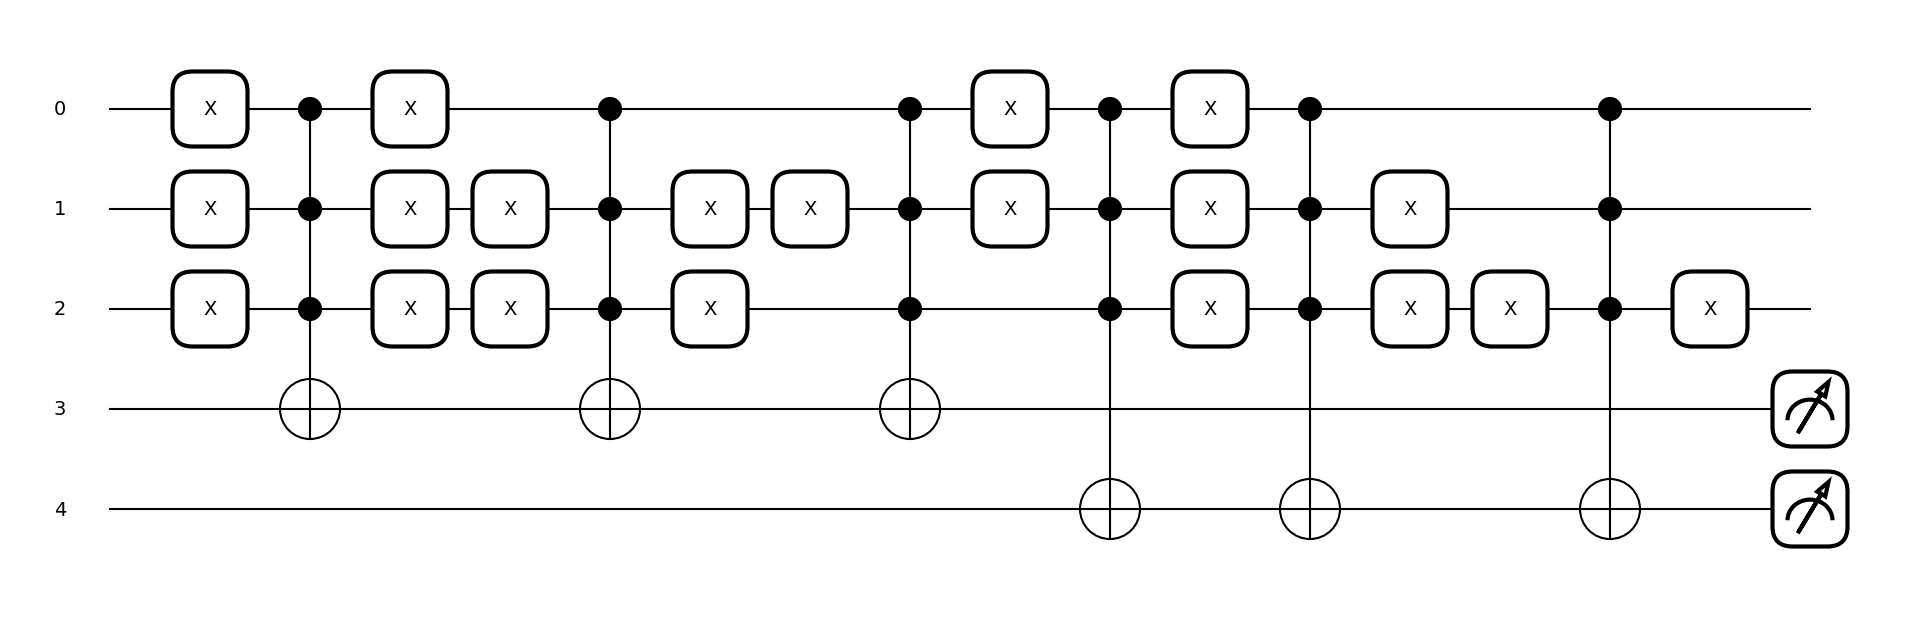

In [49]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Define a device with 5 wires:
# wires 0,1,2: input bits (a, b, c)
# wire 3: output for f
# wire 4: output for g
n_wires = 5
dev = qml.device("default.qubit", wires=n_wires, shots=1024)

@qml.qnode(dev)
def oracle_circuit(inputs):
    """Quantum circuit implementing the Boolean oracle.
    
    It prepares the input bits on wires 0,1,2 and then, for each minterm,
    conditionally flips the output qubits (wire 3 for f, wire 4 for g)
    using a multi-controlled X gate. The conditions are enforced by applying
    X gates (and then uncomputing them) on controls that are required to be 0.
    """
    # --- Prepare the input state on wires 0, 1, 2 (a, b, c) ---
    for i, bit in enumerate(inputs):
        if bit == 1:
            qml.PauliX(wires=i)
    
    # --- Compute f on wire 3 ---
    # f = 1 for (a,b,c) = (0,0,0)
    # Condition: a = 0, b = 0, c = 0 → flip all three controls first.
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    qml.MultiControlledX(wires=[0, 1, 2, 3])
    qml.PauliX(wires=0)
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    
    # f = 1 for (a,b,c) = (1,0,0)
    # Condition: a = 1, b = 0, c = 0 → flip b and c.
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    qml.MultiControlledX(wires=[0, 1, 2, 3])
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    
    # f = 1 for (a,b,c) = (1,0,1)
    # Condition: a = 1, b = 0, c = 1 → flip b.
    qml.PauliX(wires=1)
    qml.MultiControlledX(wires=[0, 1, 2, 3])
    qml.PauliX(wires=1)
    
    # --- Compute g on wire 4 ---
    # g = 1 for (a,b,c) = (0,1,1)
    # Condition: a = 0, b = 1, c = 1 → flip a.
    qml.PauliX(wires=0)
    qml.MultiControlledX(wires=[0, 1, 2, 4])
    qml.PauliX(wires=0)
    
    # g = 1 for (a,b,c) = (1,0,0)
    # Condition: a = 1, b = 0, c = 0 → flip b and c.
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    qml.MultiControlledX(wires=[0, 1, 2, 4])
    qml.PauliX(wires=1)
    qml.PauliX(wires=2)
    
    # g = 1 for (a,b,c) = (1,1,0)
    # Condition: a = 1, b = 1, c = 0 → flip c.
    qml.PauliX(wires=2)
    qml.MultiControlledX(wires=[0, 1, 2, 4])
    qml.PauliX(wires=2)
    
    # Return samples from the output wires (f and g)
    return qml.sample(wires=[3, 4])

# Draw the circuit for one example (e.g. inputs = [0, 0, 0])
plt.figure(figsize=(12, 4))
circuit_drawer = qml.draw_mpl(oracle_circuit)
circuit_drawer([0, 0, 0])
plt.show()


In [64]:
def test_oracle():
    """Verify that the oracle returns the correct outputs for each input.
    
    The truth table is defined as a list of tuples:
      (a, b, c, expected_f, expected_g)
    where `None` means "don't care".
    """
    truth_table = [
        (0, 0, 0, 1, None),  # For (0,0,0): f=1, g is don't care.
        (0, 0, 1, None, 0),
        (0, 1, 0, 0, 0),
        (0, 1, 1, 0, 1),
        (1, 0, 0, 1, 1),
        (1, 0, 1, 1, 0),
        (1, 1, 0, None, 1),
        (1, 1, 1, 0, None)
    ]
    
    for a, b, c, expected_f, expected_g in truth_table:
        # Run the circuit for the given input triple.
        # (The circuit returns an array of shape (shots, 2).)
        result = oracle_circuit([a, b, c])
        
        # Take the majority vote (via mean and rounding) over the shots.
        f = int(np.round(np.mean(result[:, 0])))
        g = int(np.round(np.mean(result[:, 1])))
        
        if expected_f is not None:
            assert f == expected_f, (
                f"Failed for input (a={a}, b={b}, c={c}): "
                f"expected f={expected_f}, got f={f}"
            )
        if expected_g is not None:
            assert g == expected_g, (
                f"Failed for input (a={a}, b={b}, c={c}): "
                f"expected g={expected_g}, got g={g}"
            )
    print("All tests passed!")

# Run the test function.
test_oracle()


All tests passed!


<Figure size 1200x400 with 0 Axes>

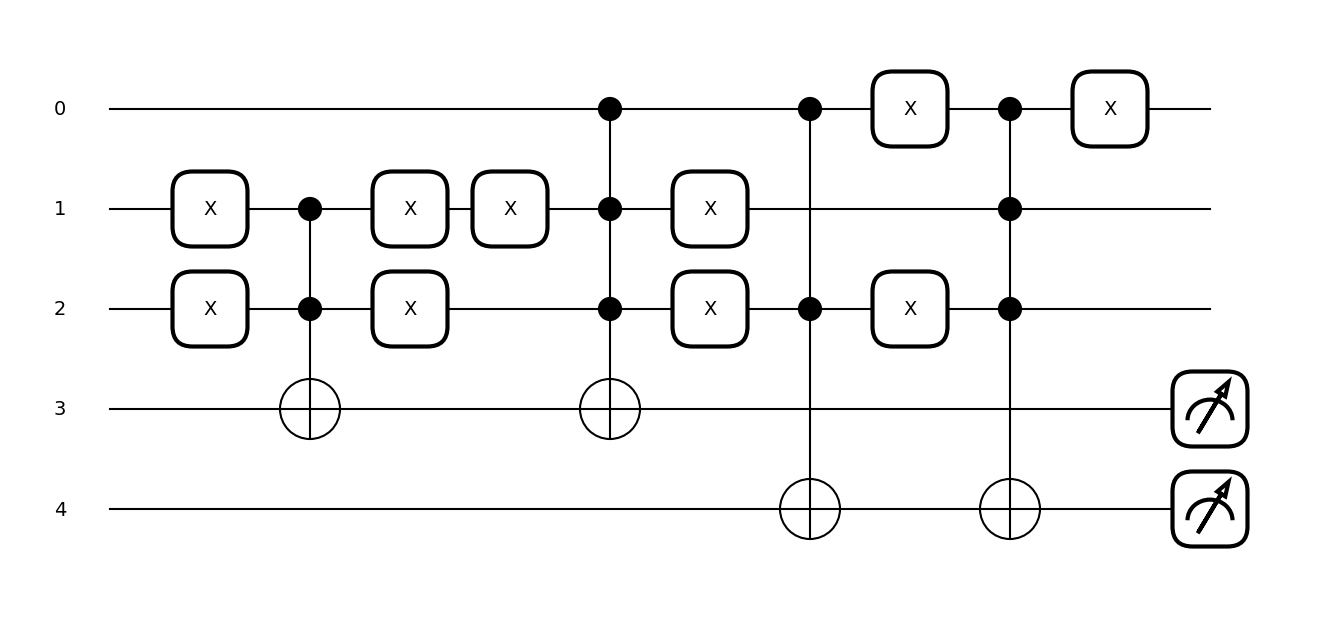

In [53]:
n_wires = 5
dev = qml.device("default.qubit", wires=n_wires, shots=1024)

@qml.qnode(dev)
def oracle_circuit(inputs):
    """
    Quantum oracle for Boolean functions f and g.
    
    The inputs are prepared on wires 0,1,2.
    We then compute:
      f = (NOT b AND NOT c) XOR (a AND NOT b AND c)
      g = (a AND NOT c) XOR (NOT a AND b AND c)
    (Here XOR is the same as OR because the terms are never simultaneously true.)
    
    We use MultiControlledX gates with appropriate X gates to 'control on 0'.
    """
    # --- Prepare the input state ---
    for i, bit in enumerate(inputs):
        if bit == 1:
            qml.PauliX(wires=i)
    
    # --- Compute f on wire 3 ---
    # Term T1 for f: NOT b and NOT c
    qml.PauliX(wires=1)  # Flip b so that NOT b becomes 1
    qml.PauliX(wires=2)  # Flip c so that NOT c becomes 1
    qml.MultiControlledX(wires=[1, 2, 3])
    qml.PauliX(wires=1)  # Uncompute
    qml.PauliX(wires=2)
    
    # Term T2 for f: a AND NOT b AND c
    qml.PauliX(wires=1)  # Flip b (since we need NOT b)
    qml.MultiControlledX(wires=[0, 1, 2, 3])
    qml.PauliX(wires=1)  # Uncompute
    
    # --- Compute g on wire 4 ---
    # Term T1 for g: a AND NOT c
    qml.PauliX(wires=2)  # Flip c (so that NOT c becomes 1)
    qml.MultiControlledX(wires=[0, 2, 4])
    qml.PauliX(wires=2)  # Uncompute
    
    # Term T2 for g: NOT a AND b AND c
    qml.PauliX(wires=0)  # Flip a (since we need NOT a)
    qml.MultiControlledX(wires=[0, 1, 2, 4])
    qml.PauliX(wires=0)  # Uncompute
    
    # Return the samples on the output wires for f (wire 3) and g (wire 4)
    #return qml.sample(wires=[3, 4])

    # Get the raw samples.
    samples = qml.sample(wires=[3, 4])
    
    return samples

# --- Draw the Circuit ---
plt.figure(figsize=(12, 4))
circuit_drawer = qml.draw_mpl(oracle_circuit)
circuit_drawer([0, 0, 0])
plt.show()


<Figure size 1200x400 with 0 Axes>

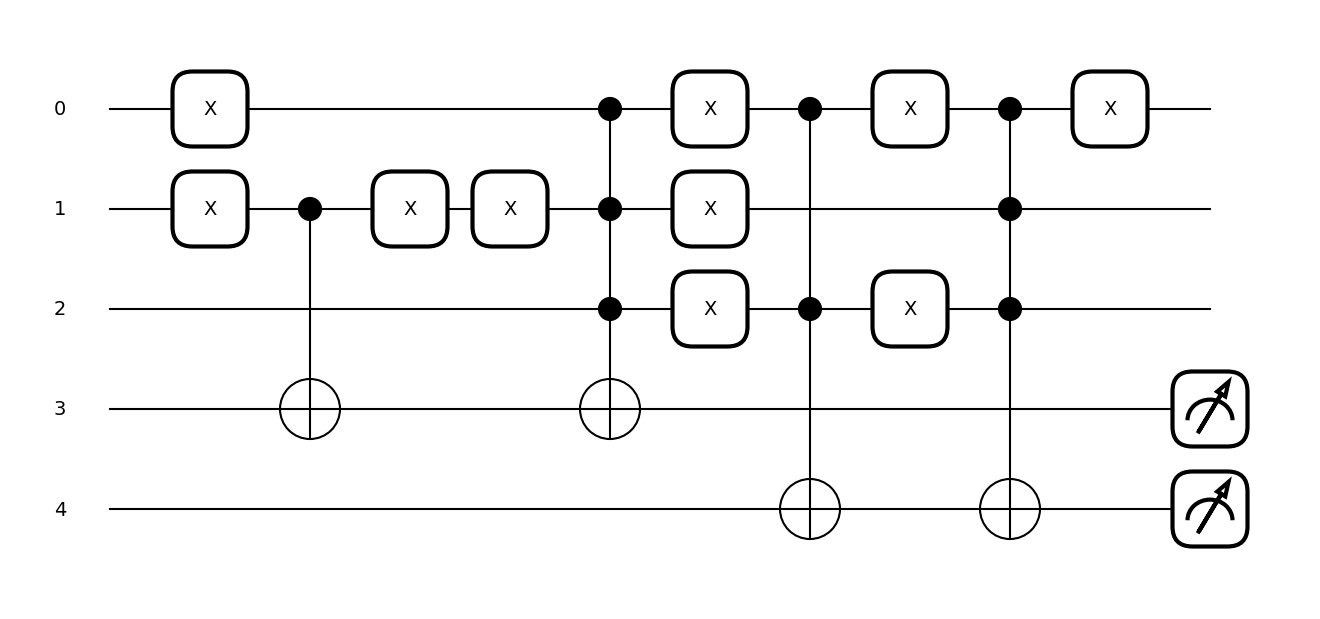

In [57]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# We work with 5 wires:
# wires 0,1,2: input bits (a, b, c)
# wire 3: output for f
# wire 4: output for g
n_wires = 5
dev = qml.device("default.qubit", wires=n_wires, shots=1024)

# A placeholder for a three-controlled NOT built from our allowed gates.
# (In practice, you would decompose it into Toffoli and CNOT gates,
#  possibly using an ancilla qubit.)
def ThreeControlledX(control_wires, target_wire):
    qml.MultiControlledX(wires=control_wires + [target_wire])

@qml.qnode(dev)
def oracle_circuit(inputs):
    """
    Oracle implementing:
      f(a,b,c) = ¬b ∧ (a ∨ ¬c)
      g(a,b,c) = (a ∧ ¬c) ∨ (¬a ∧ b ∧ c)
    using only Hadamard, PauliX, CNOT, and Toffoli (plus a helper three-controlled gate).
    """
    # --- Prepare the input state on wires 0, 1, 2 (a, b, c) ---
    for i, bit in enumerate(inputs):
        if bit == 1:
            qml.PauliX(wires=i)
    
    ### Compute f on wire 3 = ¬b ∧ (a ∨ ¬c)
    # Step 1: If b = 0, then set f to 1.
    # "Control on 0" for b is achieved by sandwiching with an X on wire 1.
    qml.PauliX(wires=1)         # Flip b: now 0 becomes 1 (and 1 becomes 0)
    qml.CNOT(wires=[1, 3])       # If (flipped b)==1, then flip f.
    qml.PauliX(wires=1)         # Restore b.
    
    # Step 2: If (b=0 and a=0 and c=1) then we must undo that flip.
    # In our language, subtract the extra flip when ¬b ∧ ¬a ∧ c is true.
    # To check control on 0 for both a and b, we apply X’s on wires 0 and 1.
    qml.PauliX(wires=1)         # Flip b so that b==0 becomes 1.
    qml.PauliX(wires=0)         # Flip a so that a==0 becomes 1.
    # Now, if (flipped b)==1, (flipped a)==1, and c==1, then subtract (flip f).
    ThreeControlledX(control_wires=[1, 0, 2], target_wire=3)
    qml.PauliX(wires=0)         # Restore a.
    qml.PauliX(wires=1)         # Restore b.
    
    ### Compute g on wire 4 = (a ∧ ¬c) ∨ (¬a ∧ b ∧ c)
    # Term 1: If a = 1 and c = 0 then flip g.
    qml.PauliX(wires=2)         # Flip c so that c==0 becomes 1 (control on ¬c)
    qml.Toffoli(wires=[0, 2, 4])  # If a and (flipped c) are 1, then flip g.
    qml.PauliX(wires=2)         # Restore c.
    
    # Term 2: If a = 0, b = 1, and c = 1 then flip g.
    qml.PauliX(wires=0)         # Flip a so that a==0 becomes 1 (control on ¬a)
    ThreeControlledX(control_wires=[0, 1, 2], target_wire=4)  # Control on (flipped a, b, c).
    qml.PauliX(wires=0)         # Restore a.
    
    return qml.sample(wires=[3, 4])

# Draw the circuit for one example (e.g. inputs = [0, 0, 0])
plt.figure(figsize=(12, 4))
circuit_drawer = qml.draw_mpl(oracle_circuit)
circuit_drawer([0, 0, 0])
plt.show()


<Figure size 1200x400 with 0 Axes>

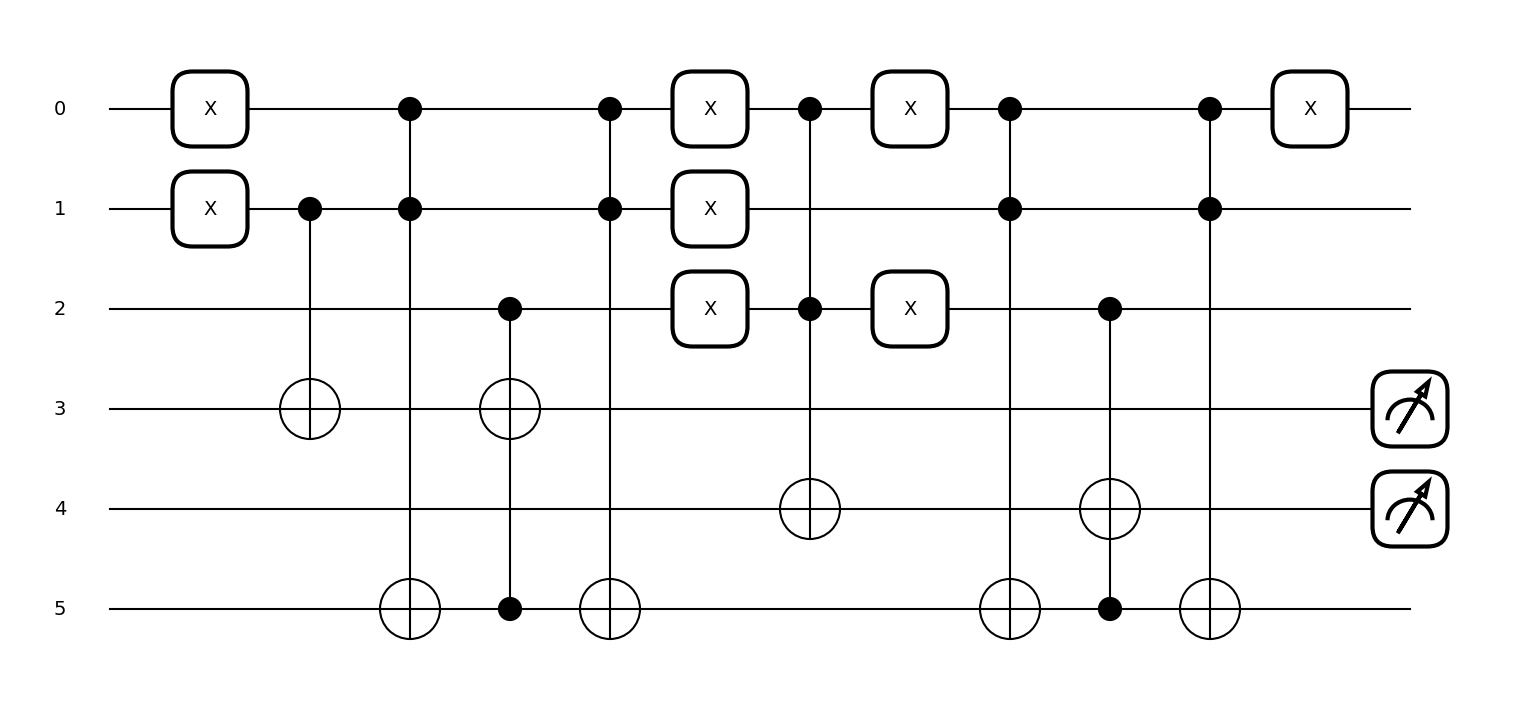

In [63]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# We now use 6 wires:
# wires 0,1,2: input bits (a, b, c)
# wire 3: output for f
# wire 4: output for g
# wire 5: ancilla for multi-controlled gates
n_wires = 6
dev = qml.device("default.qubit", wires=n_wires, shots=1024)

# def ThreeControlledX(control_wires, target_wire, ancilla_wire):
#     """
#     Decomposes a three-controlled X (NOT) gate using one ancilla.
    
#     Given three control wires (in control_wires, a list of 3 qubit indices) and 
#     a target_wire, the following steps are performed:
    
#       1. Compute the AND of control_wires[0] and control_wires[1] into the ancilla.
#       2. Use a Toffoli with controls (ancilla, control_wires[2]) to flip the target.
#       3. Uncompute the ancilla.
      
#     The ancilla is assumed to be initialized in |0>.
#     """
#     # Step 1: Compute the AND of the first two controls into ancilla.
#     qml.Toffoli(wires=[control_wires[0], control_wires[1], ancilla_wire])
#     # Step 2: Use ancilla and third control to flip the target.
#     qml.Toffoli(wires=[ancilla_wire, control_wires[2], target_wire])
#     # Step 3: Uncompute the ancilla.
#     qml.Toffoli(wires=[control_wires[0], control_wires[1], ancilla_wire])
    
@qml.qnode(dev)
def oracle_circuit(inputs):
    """
    Oracle implementing:
      f(a,b,c) = ¬b ∧ (a ∨ ¬c)
      g(a,b,c) = (a ∧ ¬c) ∨ (¬a ∧ b ∧ c)
      
    This circuit uses only Hadamard, PauliX, CNOT, and Toffoli gates.
    The three-controlled X gate is decomposed using an extra ancilla (wire 5).
    """
    # --- Prepare the input state on wires 0, 1, 2 (a, b, c) ---
    for i, bit in enumerate(inputs):
        if bit == 1:
            qml.PauliX(wires=i)
    
    ### Compute f on wire 3 = ¬b ∧ (a ∨ ¬c)
    # Step 1: If b == 0 then set f to 1.
    # Use an X on wire 1 to control on b == 0.
    qml.PauliX(wires=1)         # b: 0 -> 1 (control becomes active)
    qml.CNOT(wires=[1, 3])      # If flipped b==1, then flip f.
    #qml.PauliX(wires=1)         # Restore b.
    
    # Step 2: Subtract the unwanted case when (a ∨ ¬c) is false,
    # i.e. when a==0 and c==1, but only when b==0.
    # For this, we need to condition on b==0, a==0, and c==1.
    # We flip b and a to control on 0.
    #qml.PauliX(wires=1)         # Flip b: now b==0 becomes 1.
    qml.PauliX(wires=0)         # Flip a: now a==0 becomes 1.
    # Now, if flipped b (wire 1), flipped a (wire 0), and c (wire 2) are all 1,
    # subtract (flip) the previous flip on f.
    #ThreeControlledX(control_wires=[1, 0, 2], target_wire=3, ancilla_wire=5)

    # Step 1: Compute the AND of the first two controls into ancilla.
    qml.Toffoli(wires=[1, 0, 5])
    # Step 2: Use ancilla and third control to flip the target.
    qml.Toffoli(wires=[5, 2, 3])
    # Step 3: Uncompute the ancilla.
    qml.Toffoli(wires=[1, 0, 5])
    
    qml.PauliX(wires=0)         # Restore a.
    qml.PauliX(wires=1)         # Restore b.
    
    ### Compute g on wire 4 = (a ∧ ¬c) ∨ (¬a ∧ b ∧ c)
    # Term 1: If a==1 and c==0 then flip g.
    qml.PauliX(wires=2)         # Flip c so that c==0 becomes 1 (control on ¬c).
    qml.Toffoli(wires=[0, 2, 4])
    qml.PauliX(wires=2)         # Restore c.
    
    # Term 2: If a==0, b==1, and c==1 then flip g.
    qml.PauliX(wires=0)         # Flip a so that a==0 becomes 1 (control on ¬a).
    #ThreeControlledX(control_wires=[0, 1, 2], target_wire=4, ancilla_wire=5)

    # Step 1: Compute the AND of the first two controls into ancilla.
    qml.Toffoli(wires=[0, 1, 5])
    # Step 2: Use ancilla and third control to flip the target.
    qml.Toffoli(wires=[5, 2, 4])
    # Step 3: Uncompute the ancilla.
    qml.Toffoli(wires=[0, 1, 5])
    
    qml.PauliX(wires=0)         # Restore a.
    
    return qml.sample(wires=[3, 4])

# Draw the circuit for one example (e.g. inputs = [0, 0, 0])
plt.figure(figsize=(12, 4))
circuit_drawer = qml.draw_mpl(oracle_circuit)
circuit_drawer([0, 0, 0])
plt.show()
